In [9]:
import pandas as pd
import os
import geopandas as gpd
import geoplot as gplt
import scipy as sp
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import sys

In [10]:
wd = '/home/beeb/Insync/sei2112@columbia.edu/Google Drive/Columbia SusDev PhD/Research/My work/predictArsenic/'
placesPath = 'data/raw/googlePlaces/OLD/results.txt'
shapePath = 'data/raw/shapefiles/bgd_admbnda_adm{}_bbs_20180410/'
outPath = 'data/intermediate/placesToShapes/results.shp'
figPath = 'output/intermediate/placesToShapes/plot.png'
os.chdir(wd)

In [11]:
# read in data
dat = pd.read_json(placesPath)

In [12]:
# extract latitudes, longitudes and names
lats = [result[0]['geometry']['location']['lat'] for result in dat['results']]
lons = [result[0]['geometry']['location']['lng'] for result in dat['results']]
names = [result[0]['name'] for result in dat['results']]
formatted_address = [result[0]['formatted_address'] for result in dat['results']]

In [13]:
# put these into a geodataframe
df = pd.DataFrame(data = {'longitude': lons, 'latitude': lats},#, 'formatted_address': formatted_address}, 
                  index = names).drop_duplicates()
#gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
#gdf.head()

In [14]:
# read in the Bangladesh shapefile

In [15]:
shp = gpd.read_file(shapePath.format(0))

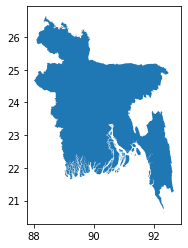

In [16]:
shp.plot()

In [17]:
# filter out any entries in our gdf which are outside Bangladesh, check 
# this doesn't involve dropping > 10% of obs
beginPointsN = df.shape[0]
df = df[df.latitude <= shp.bounds.loc[0, 'maxy']]
df = df[df.latitude >= shp.bounds.loc[0, 'miny']]
df = df[df.longitude < shp.bounds.loc[0, 'maxx']]
df = df[df.longitude >= shp.bounds.loc[0, 'minx']]
endPointsN = df.shape[0]
assert endPointsN > 0.9 * beginPointsN

In [18]:
df.head()

,longitude,latitude
Kanthali,89.760288,22.743338
Laupala,89.769671,22.719517
Sotal,89.763807,22.753771
Anardanga,89.810107,22.586231
Badan Haldarber,89.795461,22.609306


In [19]:
#CODE FROM THE INTERWEBS 
# this code creates a voronoi diagram within a bounding box
#https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells

eps = sys.float_info.epsilon

bounding_box = shp.bounds.loc[0, ['minx', 'maxx', 'miny', 'maxy']] # [x_min, x_max, y_min, y_max]

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor


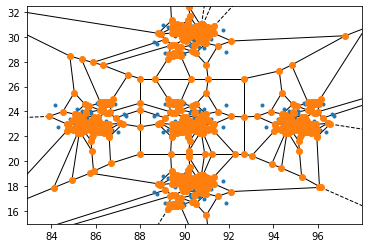

In [20]:
# make a voronoi diagram and plot it
points = np.array([[df.longitude.iloc[i], df.latitude.iloc[i]] for i in range(df.shape[0])])
vor = voronoi(points, bounding_box)
fig = voronoi_plot_2d(vor)
plt.show()

In [21]:
# wild guess at how to do this
regions = [region for region in vor.filtered_regions if len(region) > 0]

# function for turning the voronoi objects into polygons
def getPoly(pointIndices):
    
    # get the vertices for this polygon
    poly = vor.vertices[pointIndices,:]
    
    # turn this into a polygon object
    poly = Polygon(poly)
    
    # check the polygon is valid (i.e. it does not cross itself)
    if not poly.is_valid:
        print('Invalid')
        
    # give it the CRS that Google uses
    poly.crs = 'EPSG:4326'
    return(poly)

polygons = [getPoly(pointIndex) for pointIndex in regions]# if len(pointIndex) > 0]
#df['vor'] = vor.point_region

In [22]:
# check that all resulting polygons are valid
assert sum([not x.is_valid for x in polygons]) == 0

# turn the polygons into a geoseries and set the CRS
polydf = gpd.GeoSeries(polygons)
polydf.crs = 'EPSG:4326'

# clip to Bangladesh shape
polydf = gpd.clip(polydf, shp)

In [23]:
# add in the area name to each of the polygons
# let's hope that Python doesn't mix all these polygons around so they're all in the same order???
polydf.index = df.index

In [24]:
polydf.to_file(outPath)

In [25]:
polydf.head()

Kanthali           MULTIPOLYGON (((89.40697 21.84809, 89.40330 21...
Laupala            POLYGON ((88.01643 24.67764, 89.35951 23.97493...
Sotal              MULTIPOLYGON (((89.12463 23.48996, 88.99373 23...
Anardanga          POLYGON ((89.31715 24.63397, 89.35951 23.97493...
Badan Haldarber    POLYGON ((90.42028 24.48381, 90.31165 24.43204...
Name: geometry, dtype: geometry

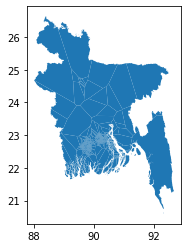

In [26]:
polydf.plot()
plt.savefig(figPath)